<a href="https://colab.research.google.com/github/geoskimoto/SNOTEL_ErrorAndOutlier_Tools/blob/fix_root/Isolationforest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Helper Functions

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotly import graph_objs as go
from functools import reduce
import requests
import xml.dom.minidom as minidom
import xml.etree.ElementTree as ET
import datetime

In [9]:
# pip install eif

In [22]:
# import eif
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

In [12]:
# Web Call to Access and Download Data of a Single Station from AWDB Web Service (SOAP API)

def SOAP_Call(stationtriplets, elementCD, begindate, enddate):

  # Create a dictionaries to store the data
  headers = {'Content-type': 'text/soap'}
  # current_dictionary = {}
  
  # Define Web Service URL
  URL = "https://wcc.sc.egov.usda.gov/awdbWebService/services?WSDL"

  # Define Parameters for SOAP Elements (getData:current and getCentralTendencyData:normals)
  SOAP_current = '''
  <?xml version="1.0" encoding="UTF-8"?>
  <SOAP-ENV:Envelope xmlns:SOAP-ENV="http://schemas.xmlsoap.org/soap/envelope/" xmlns:q0="http://www.wcc.nrcs.usda.gov/ns/awdbWebService" xmlns:xsd="http://www.w3.org/2001/XMLSchema" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance">
    <SOAP-ENV:Body>
      <q0:getData>
        <stationTriplets>STATIONTRIPLETS</stationTriplets>
        <elementCd>ELEMENTCD</elementCd>   
        <ordinal>1</ordinal>
        <duration>DAILY</duration>
        <getFlags>false</getFlags>
        <beginDate>BEGINDATE</beginDate>
        <endDate>ENDDATE</endDate>
        <alwaysReturnDailyFeb29>false</alwaysReturnDailyFeb29>   
      </q0:getData>
    </SOAP-ENV:Body>
  </SOAP-ENV:Envelope>

  '''.strip()
  #Read GetData documents - If <alwaysReturnDailyFeb29> is set to true, will set a null for every non leap year on the 29th,  
  #which breaks this request when selecting date ranges that include Feb 29.
  #Possible element codes: PREC, WTEQ (Water Equivalent/SWE)
  

  # Post SOAP Elements to AWDB Web Service and process results - getData
  SOAP_current = SOAP_current.replace("ELEMENTCD", elementCD)
  SOAP_current = SOAP_current.replace("STATIONTRIPLETS", stationtriplets)
  SOAP_current = SOAP_current.replace("BEGINDATE", begindate)
  SOAP_current = SOAP_current.replace("ENDDATE", enddate)

  response_current = requests.post(URL, data=SOAP_current, headers=headers)
  xmldoc = minidom.parseString(response_current.text)

  val_length = len(xmldoc.getElementsByTagName('values'))
  data = pd.DataFrame([xmldoc.getElementsByTagName('values')[i].firstChild.data for i in range(0,val_length)])

  date = datetime.datetime.strptime(begindate, "%m/%d/%Y").date()  #https://docs.python.org/3/library/datetime.html#strftime-strptime-behavior; .date() after .strptime just tells it to make it a datetime object.  Def necessary.
  # print(date)
  Date = []                                                       
  for i in range(0, val_length): 
    date += datetime.timedelta(days=1)
    Date.append((date))

  # {str(xmldoc.getElementsByTagName('stationTriplet')[0].firstChild.data):{Date[j]:xmldoc.getElementsByTagName('values')[j].firstChild.data} for j in range(3)}

  data['Date'] = Date
  data.columns = [f'{elementCD}','Date']
  data.set_index('Date', inplace=True)
  
  data[f'{elementCD}'] = list(map(lambda x: float(x), data[f'{elementCD}']))
  
  return data

In [13]:
# Function to Download Multiple Stations at a time from AWDB Web Service

# stations = ['401:OR:SNTL', '471:ID:SNTL', '591:WA:SNTL']
def getData(stations, parameter_of_interest, begindate, enddate):
  # data = []
  # data_singleDF
  # for i in stations:
  #   data.append(SOAP_Call(stationtriplets=i,elementCD=parameter_of_interest,begindate=begindate,enddate=enddate))

  # data_singleDF =
 
  data_singleDF = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True, how='outer'), [SOAP_Call(stationtriplets=j,elementCD=parameter_of_interest,begindate=begindate,enddate=enddate) for j in stations])
  # data_singleDF.rename(columns='bla')
  data_singleDF.columns = [f'{j}' for j in stations]

  # index = np.array([data_singleDF.columns.values, data_singleDF.iloc[1].values])
  # data_singleDF = pd.MultiIndex.from_arrays(index)
  # data_singleDF = data_singleDF.iloc[1:]

  # data_singleDF.xs('price', axis=1, level=1, drop_level=False)


  return data_singleDF

# IF testing

In [47]:
DATA = getData(['401:OR:SNTL'], 'PREC', '10/01/2000', '01/30/2021')

In [15]:
data = np.array(DATA.dropna())
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
# data = pd.DataFrame(np_scaled)


# F1  = eif.iForest(data, ntrees=200, sample_size=256, ExtensionLevel=1)

NameError: ignored

In [ ]:
data

array([[ 0. ],
       [ 0. ],
       [ 0. ],
       ...,
       [19.2],
       [19.2],
       [19.2]])

In [ ]:
np_scaled

array([[-1.83831337],
       [-1.83831337],
       [-1.83831337],
       ...,
       [-0.46751603],
       [-0.46751603],
       [-0.46751603]])

In [ ]:
# F1  = eif.iForest(np_scaled, ntrees=200, sample_size=256, ExtensionLevel=1)

In [ ]:
predictions = F1.compute_paths(X_in=data)
predictions

DATA['anomaly2'] = predictions


In [ ]:
DATA.sort_values('anomaly2', ascending=False)

In [ ]:
# visualization
fig, ax = plt.subplots(figsize=(20,12))

a = DATA.loc[DATA['anomaly2'] > .76] #anomaly

ax.plot(DATA.index, DATA['401:OR:SNTL'], color='blue', label = 'Normal')
ax.scatter(a.index, a['401:OR:SNTL'], color='red', label = 'Anomaly')
plt.legend()
plt.show();

In [ ]:
F1

NameError: ignored

In [55]:
DATA = getData(['401:OR:SNTL'], 'TAVG', '10/01/2010', '01/30/2021')

In [52]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [90]:
DATA

,401:OR:SNTL
Date,
2010-10-02,NaN
2010-10-03,NaN
2010-10-04,NaN
2010-10-05,NaN
2010-10-06,NaN
...,...
2021-01-27,NaN
2021-01-28,NaN
2021-01-29,NaN


In [59]:
sd = seasonal_decompose(DATA,freq=365)

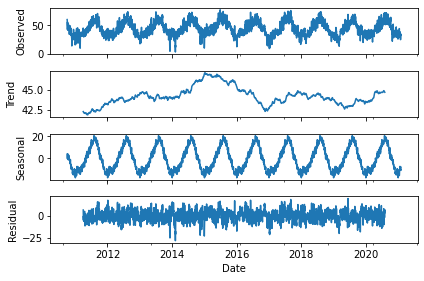

In [62]:
sd.plot();

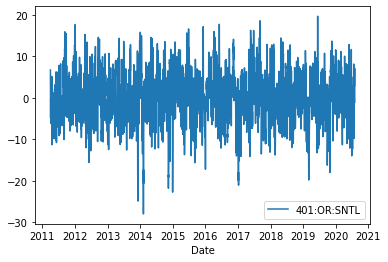

In [74]:
sd.resid.plot()

In [66]:
import statsmodels.tsa.filters as filters

In [70]:
bk = filters.bk_filter  #(x=DATA, low=6, high=32, K=12)

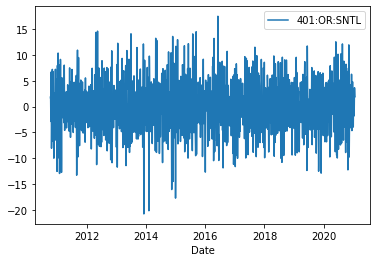

In [72]:
bk.bkfilter(DATA, low=6, high=32, K=12).plot()

In [99]:
sd.observed

,401:OR:SNTL
Date,
2010-10-02,60.08
2010-10-03,59.18
2010-10-04,49.10
2010-10-05,42.62
2010-10-06,46.22
...,...
2021-01-27,24.80
2021-01-28,30.74
2021-01-29,33.44


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



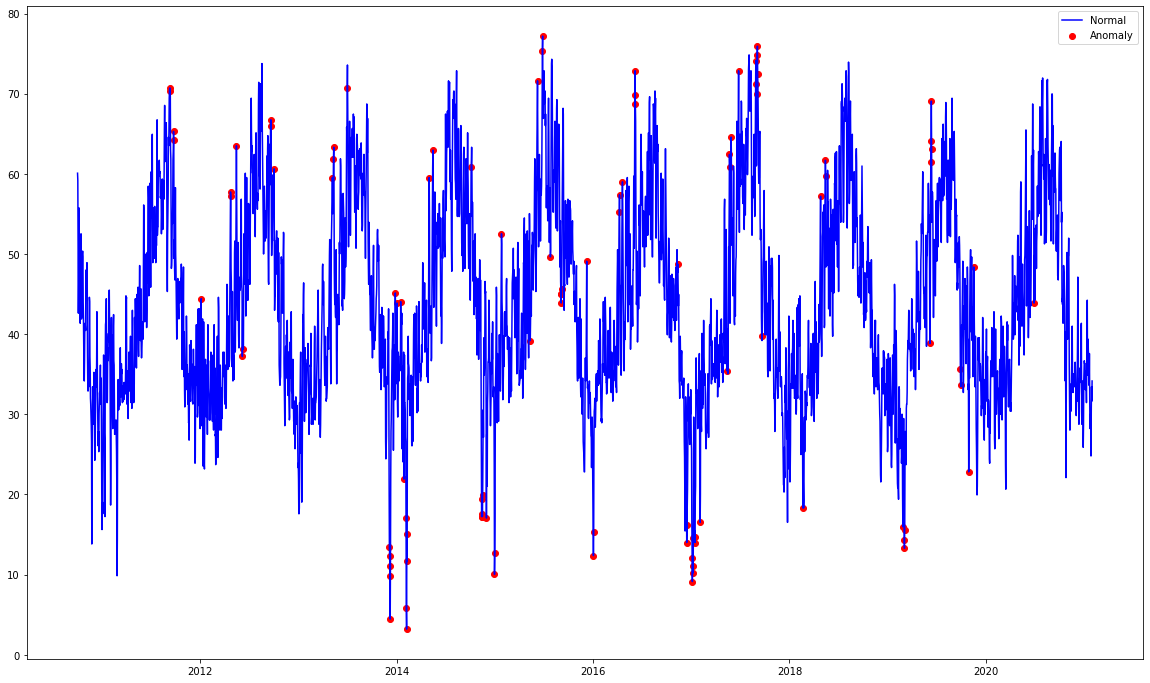

In [133]:
X = sd.resid.dropna()
X_arr = np.array(resid)
# data = DATA_array
scaler = StandardScaler()
X_arr_scaled = scaler.fit_transform(X)
X_arr_scaled = pd.DataFrame(X_arr_scaled)
# train isolation forest
model =  IsolationForest(n_estimators = 5000, contamination = 0.03, bootstrap=False)
model.fit(X_arr_scaled)

predictions = model.predict(X_arr_scaled)
# predictions = pd.DataFrame(predictions)
# X = pd.DataFrame(X)
X['anomaly'] = predictions

observed = sd.observed.dropna()
observed  = pd.merge(observed, X['anomaly'], left_index=True,right_index=True)
# observed['anomaly'] = predictions
# X_scaled['anomaly'] = predictions

# visualization
fig, ax = plt.subplots(figsize=(20,12))

anomalies = X.loc[X['anomaly'] == -1] #anomaly
anomalies2 = observed[observed['anomaly'] == -1]

observed = sd.observed #.dropna()
ax.plot(observed.index, observed.iloc[:,0], color='blue', label = 'Normal')
# ax.plot(X.index, X.iloc[:,0], color='blue', label = 'Normal')
ax.scatter(pd.to_datetime(anomalies2.index), anomalies2.iloc[:,0], color='red', label = 'Anomaly')
plt.legend()
plt.show();

In [131]:
observed[observed['anomaly']==-1]

,401:OR:SNTL,anomaly
Date,,
2011-04-22,30.74,-1
2011-06-02,39.92,-1
2011-06-09,41.54,-1
2011-09-01,45.32,-1
2011-09-08,69.44,-1
...,...,...
2020-06-29,43.88,-1
2020-06-30,49.82,-1
2020-07-01,48.38,-1


In [109]:
anomalies

,0,anomaly
20,-11.332389,-1
68,-10.809107,-1
156,9.734565,-1
159,11.729469,-1
160,11.451989,-1
...,...,...
3376,-14.002652,-1
3377,-11.846498,-1
3378,-10.540192,-1
3379,-11.192679,-1


In [119]:
X.dropna()

,401:OR:SNTL,anomaly
Date,,


In [124]:
X[X['anomaly']==-1]

,401:OR:SNTL,anomaly
Date,,
2011-04-22,-11.332389,-1
2011-06-09,-10.809107,-1
2011-09-05,9.734565,-1
2011-09-08,11.729469,-1
2011-09-09,11.451989,-1
...,...,...
2020-06-29,-14.002652,-1
2020-06-30,-11.846498,-1
2020-07-01,-10.540192,-1


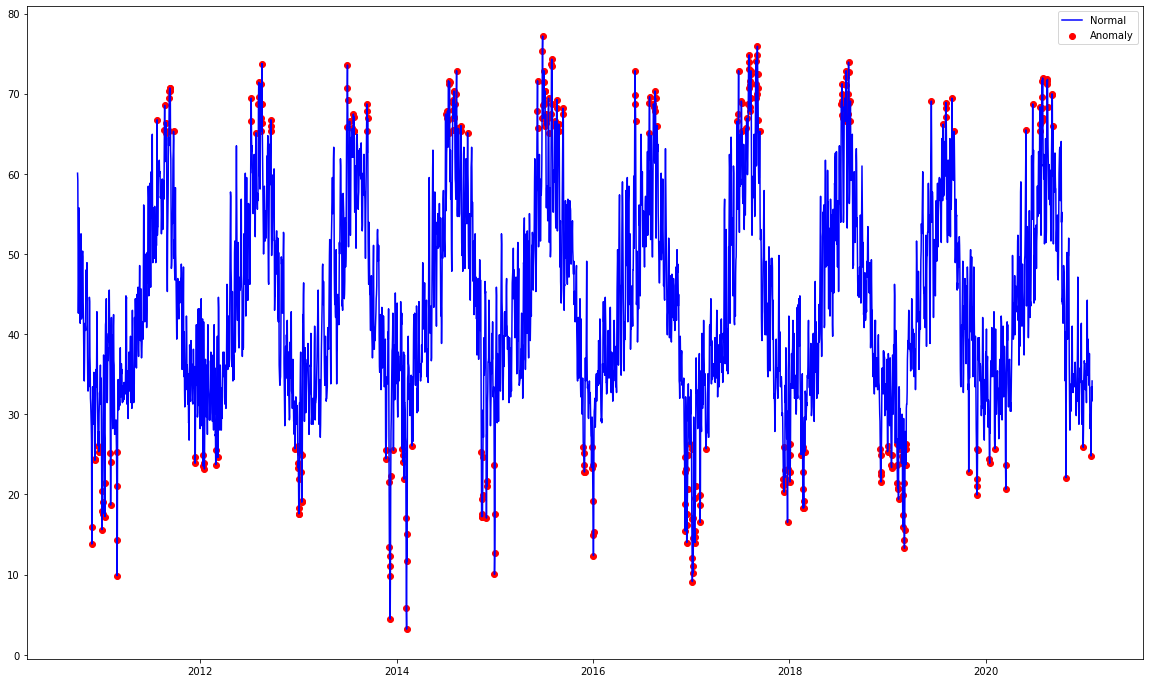

In [51]:
# outliers_fraction = 0.05
data = np.array(DATA.dropna())
# data = DATA_array
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest
model =  IsolationForest(n_estimators = 5000, contamination = 0.1, bootstrap=True)
model.fit(data) 
DATA['anomaly2'] = model.predict(data)

# visualization
fig, ax = plt.subplots(figsize=(20,12))

a = DATA.loc[DATA['anomaly2'] == -1] #anomaly

ax.plot(DATA.index, DATA['401:OR:SNTL'], color='blue', label = 'Normal')
ax.scatter(a.index, a['401:OR:SNTL'], color='red', label = 'Anomaly')
plt.legend()
plt.show();